In [210]:
import request_chart as chart

In [209]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

warnings.filterwarnings("ignore")  

In [190]:
candles = chart.candle_min_30(200)

candles = pd.DataFrame(candles)

candles = candles[::-1]

candles = candles.reset_index(drop=True)

data = candles

In [191]:
data

,market,candle_date_time_utc,candle_date_time_kst,opening_price,high_price,low_price,trade_price,timestamp,candle_acc_trade_price,candle_acc_trade_volume,unit
0,KRW-BTC,2023-02-28T03:30:00,2023-02-28T12:30:00,31211000.0,31228000.0,31153000.0,31160000.0,1677556798022,2.277639e+09,73.023102,30
1,KRW-BTC,2023-02-28T04:00:00,2023-02-28T13:00:00,31160000.0,31186000.0,31121000.0,31156000.0,1677558598867,3.072423e+09,98.619746,30
2,KRW-BTC,2023-02-28T04:30:00,2023-02-28T13:30:00,31156000.0,31164000.0,31100000.0,31116000.0,1677560399144,2.996111e+09,96.256850,30
3,KRW-BTC,2023-02-28T05:00:00,2023-02-28T14:00:00,31137000.0,31216000.0,31115000.0,31155000.0,1677562198144,3.082101e+09,98.930499,30
4,KRW-BTC,2023-02-28T05:30:00,2023-02-28T14:30:00,31155000.0,31180000.0,31107000.0,31118000.0,1677563998862,1.971134e+09,63.294749,30
...,...,...,...,...,...,...,...,...,...,...,...
195,KRW-BTC,2023-03-04T05:00:00,2023-03-04T14:00:00,29786000.0,29805000.0,29764000.0,29781000.0,1677907799220,1.142428e+09,38.349671,30
196,KRW-BTC,2023-03-04T05:30:00,2023-03-04T14:30:00,29781000.0,29803000.0,29701000.0,29788000.0,1677909599909,1.832962e+09,61.555894,30
197,KRW-BTC,2023-03-04T06:00:00,2023-03-04T15:00:00,29788000.0,29861000.0,29786000.0,29852000.0,1677911398814,2.446676e+09,82.055911,30
198,KRW-BTC,2023-03-04T06:30:00,2023-03-04T15:30:00,29852000.0,29855000.0,29786000.0,29799000.0,1677913194377,1.795355e+09,60.209814,30


In [192]:
data['candle_date_time_utc'] = pd.to_datetime(data['candle_date_time_utc'])

In [193]:
# 30분을 1으로 변환

data['time_idx'] = (
    data['candle_date_time_utc'].dt.year * 17520 +
    data['candle_date_time_utc'].dt.month * 1440 +
    data['candle_date_time_utc'].dt.day * 48 +
    data['candle_date_time_utc'].dt.hour / 0.5 +
    data['candle_date_time_utc'].dt.minute / 30
)

data['time_idx'] -= data["time_idx"].min()

data['time_idx'] = data['time_idx'].astype(int)

In [194]:
# # add additional features
# data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
# data["log_volume"] = np.log(data.volume + 1e-8)
# data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
# data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

# # we want to encode special days as one variable and thus need to first reverse one-hot encoding
# special_days = [
#     "easter_day",
#     "good_friday",
#     "new_year",
#     "christmas",
#     "labor_day",
#     "independence_day",
#     "revolution_day_memorial",
#     "regional_games",
#     "fifa_u_17_world_cup",
#     "football_gold_cup",
#     "beer_capital",
#     "music_fest",
# ]
# data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
# data.sample(10, random_state=521)

In [195]:
data

,market,candle_date_time_utc,candle_date_time_kst,opening_price,high_price,low_price,trade_price,timestamp,candle_acc_trade_price,candle_acc_trade_volume,unit,time_idx
0,KRW-BTC,2023-02-28 03:30:00,2023-02-28T12:30:00,31211000.0,31228000.0,31153000.0,31160000.0,1677556798022,2.277639e+09,73.023102,30,0
1,KRW-BTC,2023-02-28 04:00:00,2023-02-28T13:00:00,31160000.0,31186000.0,31121000.0,31156000.0,1677558598867,3.072423e+09,98.619746,30,1
2,KRW-BTC,2023-02-28 04:30:00,2023-02-28T13:30:00,31156000.0,31164000.0,31100000.0,31116000.0,1677560399144,2.996111e+09,96.256850,30,2
3,KRW-BTC,2023-02-28 05:00:00,2023-02-28T14:00:00,31137000.0,31216000.0,31115000.0,31155000.0,1677562198144,3.082101e+09,98.930499,30,3
4,KRW-BTC,2023-02-28 05:30:00,2023-02-28T14:30:00,31155000.0,31180000.0,31107000.0,31118000.0,1677563998862,1.971134e+09,63.294749,30,4
...,...,...,...,...,...,...,...,...,...,...,...,...
195,KRW-BTC,2023-03-04 05:00:00,2023-03-04T14:00:00,29786000.0,29805000.0,29764000.0,29781000.0,1677907799220,1.142428e+09,38.349671,30,291
196,KRW-BTC,2023-03-04 05:30:00,2023-03-04T14:30:00,29781000.0,29803000.0,29701000.0,29788000.0,1677909599909,1.832962e+09,61.555894,30,292
197,KRW-BTC,2023-03-04 06:00:00,2023-03-04T15:00:00,29788000.0,29861000.0,29786000.0,29852000.0,1677911398814,2.446676e+09,82.055911,30,293
198,KRW-BTC,2023-03-04 06:30:00,2023-03-04T15:30:00,29852000.0,29855000.0,29786000.0,29799000.0,1677913194377,1.795355e+09,60.209814,30,294


In [196]:
max_prediction_length = 6
max_encoder_length = 50
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="trade_price",
    group_ids=['market'],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
#     static_categoricals=["agency", "sku"],
#     static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
#     time_varying_known_categoricals=["special_days", "month"],
#     variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
#     time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[],
#     target_normalizer=GroupNormalizer(
#         groups=["agency", "sku"], transformation="softplus"
#     ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

In [197]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

In [198]:
# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [199]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

24833.333984375

In [200]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
    optimizer='adam',
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 17.0k


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Restoring states from the checkpoint path at C:\Users\ndmb2\jupyter_lib\bitcoin\.lr_find_bc95b465-c325-4d68-820f-3a2443ea78be.ckpt
Restored all states from the checkpoint file at C:\Users\ndmb2\jupyter_lib\bitcoin\.lr_find_bc95b465-c325-4d68-820f-3a2443ea78be.ckpt


suggested learning rate: 0.0051286138399136505


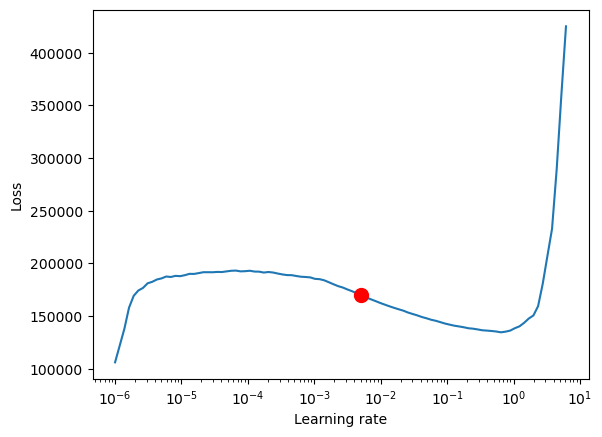

In [201]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [202]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 17.0k


In [203]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 528   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Hyperparameter tuning

In [169]:
# import pickle

# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# # create study
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test",
#     n_trials=200,
#     max_epochs=50,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(limit_train_batches=30),
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )

# # save study results - also we can resume tuning at a later point in time
# with open("test_study.pkl", "wb") as fout:
#     pickle.dump(study, fout)

# # show best hyperparameters
# print(study.best_trial.params)

# Evaluate performance

In [204]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [205]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(46275.3320)

In [206]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

IndexError: index 1 is out of bounds for dimension 0 with size 1

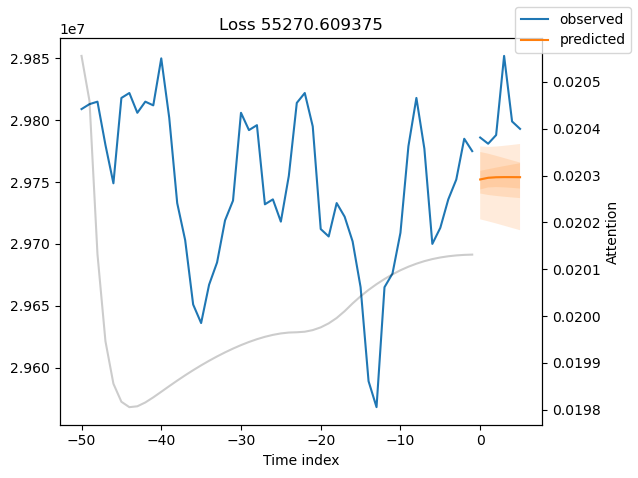

In [207]:
# for idx in range(10):  # plot 10 examples
#     best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [ ]:
# predictions, x = best_tft.predict(val_dataloader, return_x=True)
# predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
# best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

# Predict on selected data

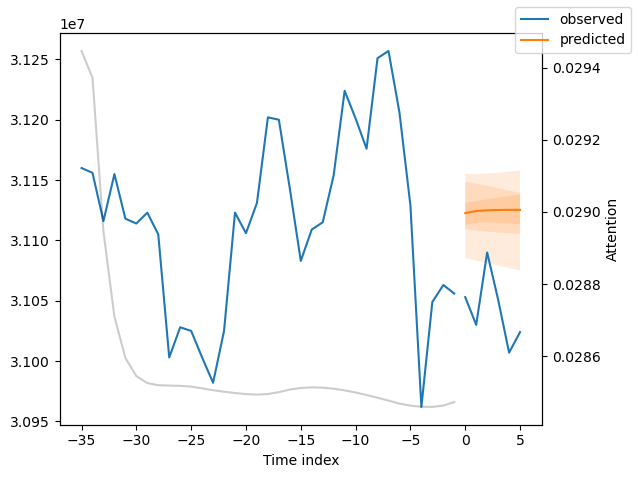

In [208]:
raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.market == "KRW-BTC")),
    mode="raw",
    return_x=True,
)

best_tft.plot_prediction(x, raw_prediction, idx=0);